<a href="https://colab.research.google.com/github/mohd-raza/MNIST/blob/main/MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models
# from torch.utils.data import SubsetRandomSampler
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

In [4]:
train = pd.read_csv("/content/drive/MyDrive/MNIST/train.csv",dtype=np.float32)
final_test = pd.read_csv("/content/drive/MyDrive/MNIST/test.csv",dtype=np.float32)

In [5]:
train.label.head()

0    1.0
1    0.0
2    1.0
3    4.0
4    0.0
Name: label, dtype: float32

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


In [7]:
# seperate the features and labels
target_np = train.label.values
features_np = train.loc[:,train.columns != 'label'].values/255

In [8]:
features_train,features_test,target_train,target_test = train_test_split(
    features_np,target_np,test_size=0.2,random_state=42
)

In [9]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

In [10]:
# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor) # data type is long

In [11]:
batch_size = 256
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

(784,)


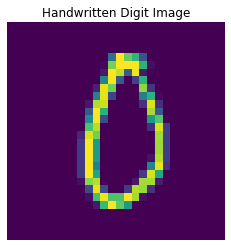

In [14]:
# visualize one of the images in data set
def visualize_image(data, index, pred=False, val=0):
    '''This funtion can be used to visualize the images'''
    print(data[index].shape)
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title("Handwritten Digit Image")
    plt.show()
visualize_image(features_np, 69)

In [15]:
featuresTrain.shape

torch.Size([33600, 784])

In [19]:
class Classifier(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    #  5 Hidden Layer Network
    self.fc1 = nn.Linear(28*28,512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64,10)

    # Dropout module with 0.2 probbability
    self.dropout = nn.Dropout(p=0.2)
    # Add softmax on output layer
    self.log_softmax = F.log_softmax
  
  def forward(self,x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
        
    x = self.log_softmax(self.fc5(x), dim=1)
    return x 

# Training & Validation

In [20]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0010)

epochs = 25
steps = 0
print_every = 50
train_losses,test_losses = [],[]
for e in range (epochs):
  running_loss = 0
  for images,labels in train_loader:
    steps += 1
    # Prevent accumulation of gradients
    optimizer.zero_grad()
    # make pred
    log_ps = model(images)
    loss = criterion(log_ps,labels)
    # backprop
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0

      with torch.no_grad():
        model.eval()
        for images,labels in test_loader:
          log_ps = model(images)
          test_loss += criterion(log_ps,labels)
          ps = torch.exp(log_ps)
          # get our top pred
          top_p,top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      model.train()
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(test_loss/len(test_loader))
      print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))


Epoch: 1/25..  Training Loss: 0.499..  Test Loss: 0.478..  Test Accuracy: 0.860
Epoch: 1/25..  Training Loss: 0.683..  Test Loss: 0.308..  Test Accuracy: 0.908
Epoch: 2/25..  Training Loss: 0.042..  Test Loss: 0.258..  Test Accuracy: 0.924
Epoch: 2/25..  Training Loss: 0.142..  Test Loss: 0.211..  Test Accuracy: 0.938
Epoch: 2/25..  Training Loss: 0.227..  Test Loss: 0.179..  Test Accuracy: 0.947
Epoch: 3/25..  Training Loss: 0.048..  Test Loss: 0.158..  Test Accuracy: 0.952
Epoch: 3/25..  Training Loss: 0.113..  Test Loss: 0.151..  Test Accuracy: 0.955
Epoch: 4/25..  Training Loss: 0.004..  Test Loss: 0.136..  Test Accuracy: 0.959
Epoch: 4/25..  Training Loss: 0.052..  Test Loss: 0.126..  Test Accuracy: 0.962
Epoch: 4/25..  Training Loss: 0.101..  Test Loss: 0.119..  Test Accuracy: 0.964
Epoch: 5/25..  Training Loss: 0.018..  Test Loss: 0.117..  Test Accuracy: 0.966
Epoch: 5/25..  Training Loss: 0.059..  Test Loss: 0.111..  Test Accuracy: 0.968
Epoch: 5/25..  Training Loss: 0.097..  T

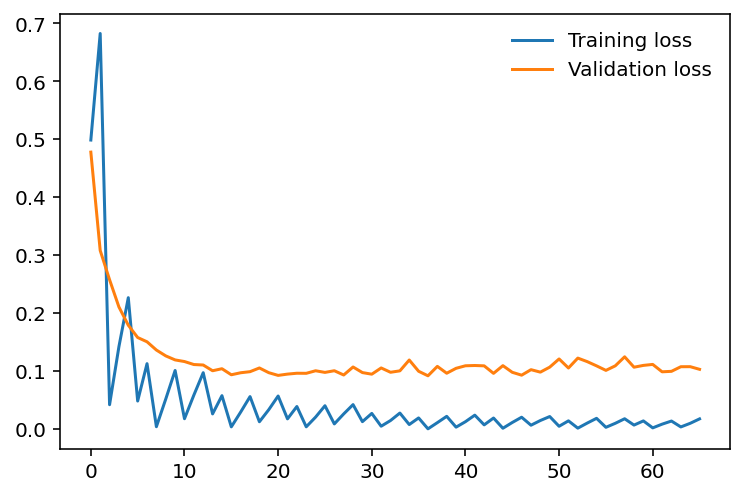

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [22]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

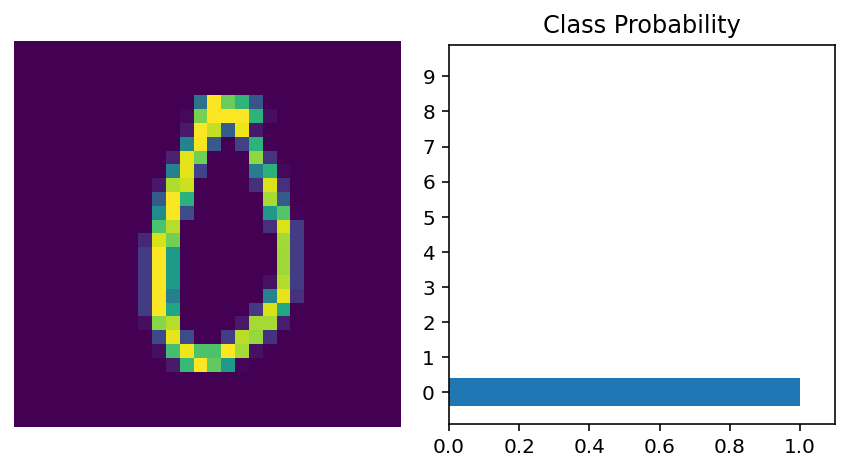

In [25]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[69].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(test_loader)

In [26]:
final_test_np = final_test.values/255
test_tn = torch.from_numpy(final_test_np)

In [27]:
#  Creating fake labels for convenience of passing into DataLoader
## CAUTION: There are other ways of doing this, I just did it this way
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [28]:
submission_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)

submission_loader = torch.utils.data.DataLoader(submission_tn_data, batch_size = batch_size, shuffle = False)

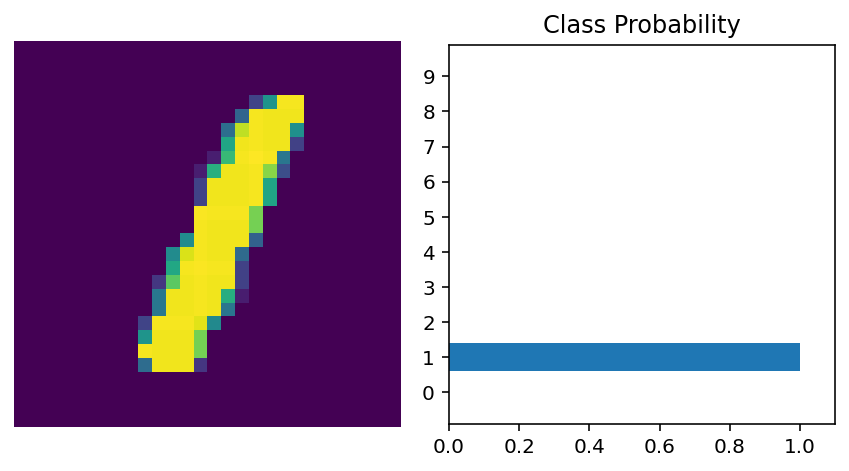

In [30]:
# Seeing what our model does on test data
make_prediction(submission_loader)

In [31]:
# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in submission_loader:
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1